In [1]:
# Check if all the sessions are closed
from tensorflow.compat.v1 import ConfigProto, InteractiveSession, get_default_session

# Ensure all previous sessions are closed
try:
    current_session = get_default_session()
    if current_session is not None:
        current_session.close()
        print("session Closed")
except:
    print("No session")
    pass  # This handles cases where there’s no active session
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [1]:
#importing required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from glob import glob

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3    # importing required InceptionV3 model architecture
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam # importing optimizer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# Set the paths for your training and validation datasets
train_path = 'D:/Hackathon_CNN/DevNetHackathonData/Plants_2/train'
valid_path = 'D:/Hackathon_CNN/DevNetHackathonData/Plants_2/test'


In [7]:
folders = glob('D:/Hackathon_CNN/DevNetHackathonData/Plants_2/train/*')

In [9]:
num_classes=len(folders)
num_classes  # there are 22 classes in the train dataset

In [11]:
IMAGE_SIZE = [299, 299] 

### Image Preprocessing, Augmentation, and Data Generators for Training and Validation

In [13]:
# Image preprocessing and augmentation
# creates an image data generator for training that applies various transformations (like rotation, shifting, zooming, and flipping)
#to augment the training data and improve model generalization.
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,         
    rotation_range=40,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=True,      
    fill_mode='nearest'        
)

#creates an image data generator for validation that only rescales the pixel values to the range [0, 1], 
#without any augmentation, ensuring consistent evaluation of the model.

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)  


batch_size = 16
img_height, img_width = 299, 299  # InceptionV3 requires 299x299 input size

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',    
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',    
    shuffle=False
)


Found 4274 images belonging to 22 classes.
Found 110 images belonging to 22 classes.


### Building a Custom InceptionV3 Model for Image Classification

In [15]:
# Load InceptionV3 model without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + [3])

# Freeze the base model layers (we don't want to update them during training)
base_model.trainable = False

# Build the custom classifier on top of the InceptionV3 base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce the dimensions (we are avoiding flattening() to reduce overfitting)
    layers.Dense(1024, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout to avoid overfitting
    layers.Dense(num_classes, activation='softmax')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), ## mostly used optimizer
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │          22,550 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,923,510 (91.26 MB)

 Trainable params: 2,120,726 (8.09 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### Training the model

In [17]:
#helps to prevent overfitting by stopping the training early if the model's performance on the validation set isn't improving anymore.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#ensures that you always have the best model based on validation performance, not just the last epoch.
model_checkpoint = ModelCheckpoint('best_plant_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

C:\Users\vishw\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.4065 - loss: 2.0741 - val_accuracy: 0.7500 - val_loss: 0.8248
Epoch 2/15
  1/267 ━━━━━━━━━━━━━━━━━━━━ 1:30 340ms/step - accuracy: 0.4375 - loss: 1.1687

C:\Users\vishw\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4375 - loss: 1.1687 - val_accuracy: 0.5714 - val_loss: 1.1076
Epoch 3/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 906s 3s/step - accuracy: 0.6946 - loss: 0.8965 - val_accuracy: 0.7812 - val_loss: 0.6988
Epoch 4/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7500 - loss: 0.7483 - val_accuracy: 0.5714 - val_loss: 0.9497
Epoch 5/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 2820s 11s/step - accuracy: 0.7295 - loss: 0.8049 - val_accuracy: 0.7708 - val_loss: 0.6076
Epoch 6/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8125 - loss: 0.4907 - val_accuracy: 0.7857 - val_loss: 0.5285
Epoch 7/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 2865s 11s/step - accuracy: 0.7682 - loss: 0.6833 - val_accuracy: 0.7708 - val_loss: 0.6187
Epoch 8/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8750 - loss: 0.6435 - val_accuracy: 0.7143 - val_loss: 0.6355
Epoch 9/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 2911s 11s/step - accuracy: 0.7728 - loss: 0.6424 - val_accuracy

### Save the Model

In [21]:
model.save(r'D:\Hackathon_CNN\final_plant_model_v2.keras')
model.save(r'D:\Hackathon_CNN\final_plant_model_v2.h5')

### Plotting Training and Validation Loss & Accuracy

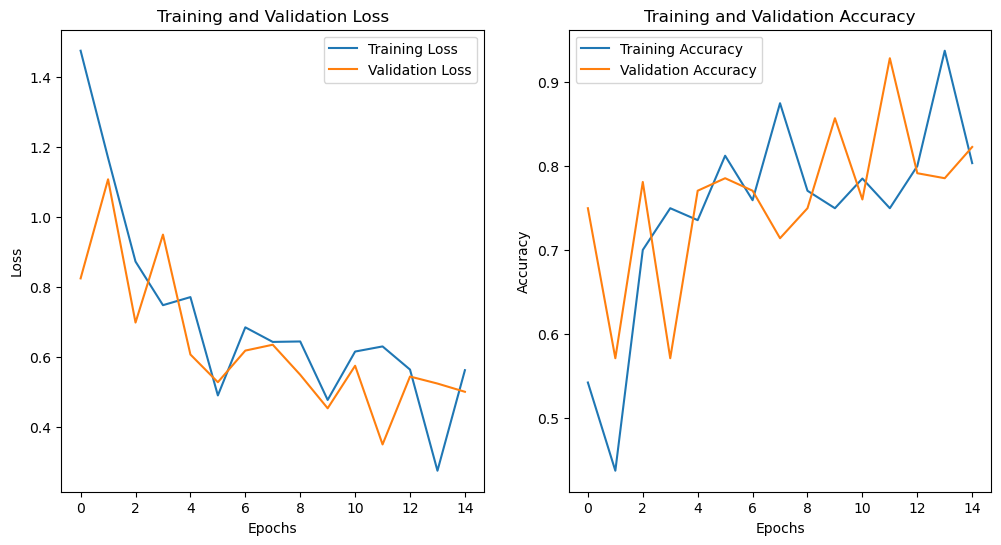

In [23]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Evaluating Model Performance: Confusion Matrix and Classification Report

7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step


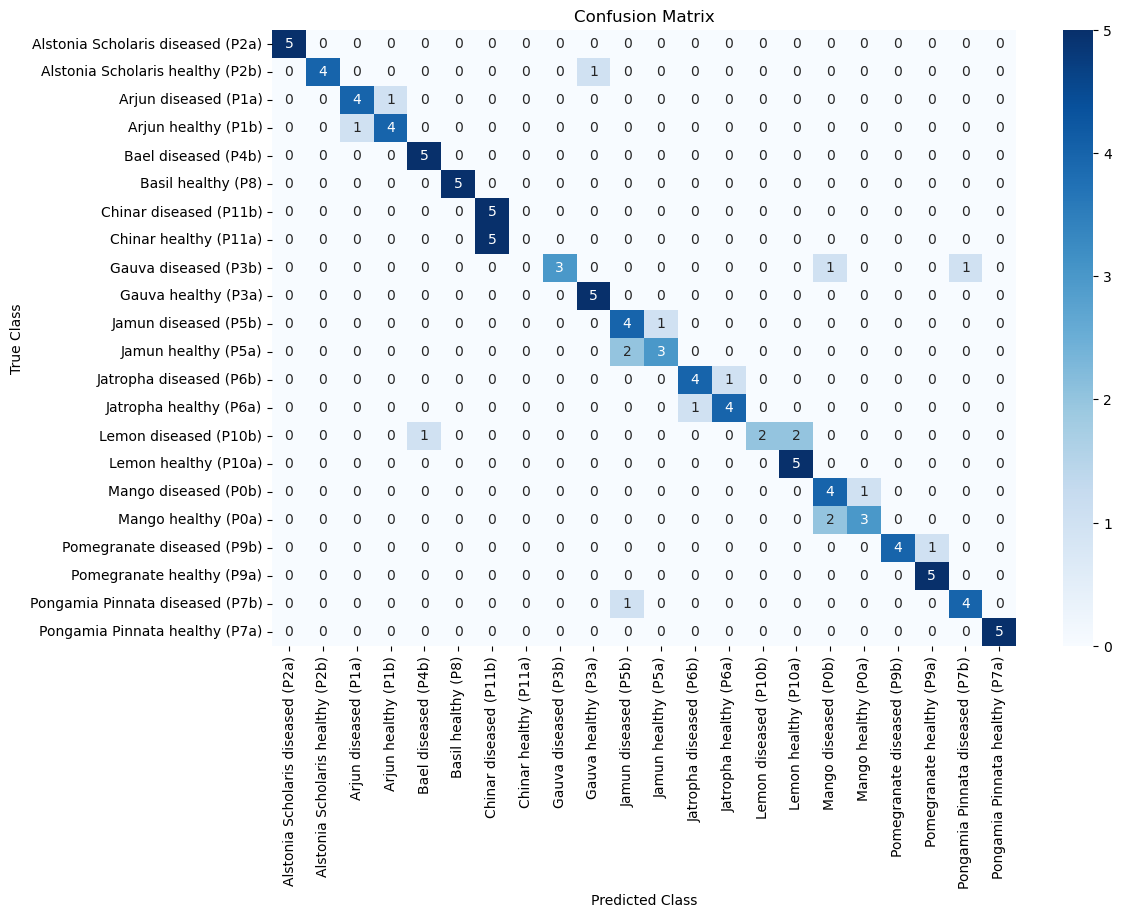

                                   precision    recall  f1-score   support

Alstonia Scholaris diseased (P2a)       1.00      1.00      1.00         5
 Alstonia Scholaris healthy (P2b)       1.00      0.80      0.89         5
             Arjun diseased (P1a)       0.80      0.80      0.80         5
              Arjun healthy (P1b)       0.80      0.80      0.80         5
              Bael diseased (P4b)       0.83      1.00      0.91         5
               Basil healthy (P8)       1.00      1.00      1.00         5
           Chinar diseased (P11b)       0.50      1.00      0.67         5
            Chinar healthy (P11a)       0.00      0.00      0.00         5
             Gauva diseased (P3b)       1.00      0.60      0.75         5
              Gauva healthy (P3a)       0.83      1.00      0.91         5
             Jamun diseased (P5b)       0.57      0.80      0.67         5
              Jamun healthy (P5a)       0.75      0.60      0.67         5
          Jatropha disea

C:\Users\vishw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vishw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vishw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Reset the validation generator before making predictions
valid_generator.reset()

# Calculate the number of steps
steps = np.ceil(valid_generator.samples / valid_generator.batch_size).astype(int)

# Get predictions
predictions = model.predict(valid_generator, steps=steps, verbose=1)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = valid_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=valid_generator.class_indices.keys()))
